# Bias-field coherent quantum annealing

## Imports

In [1]:
from utils import *

from dwave.system import EmbeddingComposite, DWaveSampler, FixedEmbeddingComposite
from dwave.system.temperatures import h_to_fluxbias
from dwave.samplers import *

from minorminer import find_embedding

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['mathtext.fontset'] = 'dejavusans'
matplotlib.rcParams['font.family'] = 'sans-serif'

## Define random problem instance

In [2]:
# Test a random Ising problem
seed = 10
num_qubits = 20
connectivity = 'fully'

# Instantiate the problem
h, J = create_problem(num_qubits=num_qubits, seed=seed, connectivity=connectivity)
print('h=', h)
print('J=', J)

h= {0: 0.771320643266746, 1: 0.0207519493594015, 2: 0.6336482349262754, 3: 0.7488038825386119, 4: 0.4985070123025904, 5: 0.22479664553084766, 6: 0.19806286475962398, 7: 0.7605307121989587, 8: 0.16911083656253545, 9: 0.08833981417401027, 10: 0.6853598183677972, 11: 0.9533933461949365, 12: 0.003948266327914451, 13: 0.5121922633857766, 14: 0.8126209616521135, 15: 0.6125260668293881, 16: 0.7217553174317995, 17: 0.29187606817063316, 18: 0.9177741225129434, 19: 0.7145757833976906}
J= {(0, 1): np.float64(-1.1366022118310442), (0, 2): np.float64(0.1351368784486355), (0, 3): np.float64(1.4845370018365827), (0, 4): np.float64(-1.0798048857852762), (0, 5): np.float64(-1.977728280657907), (0, 6): np.float64(-1.7433722958989073), (0, 7): np.float64(0.266070164000551), (0, 8): np.float64(2.384967330711097), (0, 9): np.float64(1.1236912534094234), (0, 10): np.float64(1.6726222133078277), (0, 11): np.float64(0.09914921583524362), (0, 12): np.float64(1.3979963770935753), (0, 13): np.float64(-0.27124798

In [3]:
# solve using simulated annealing for comparison
num_reads = 3000
sampler_sa = SimulatedAnnealingSampler()
sampleset = sampler_sa.sample_ising(h, J, num_reads =num_reads, num_sweeps=10000)
sampleset_sa = sampleset.aggregate()

In [4]:
for data in sampleset_sa.data(fields=['sample', 'num_occurrences', 'energy']):
        gs_sa = ''.join(str(int((1-s)/2)) for s in list(data.sample.values()))
        gs_energy_sa = get_energy(h, J, data.sample)
        print("Min: ",gs_sa, gs_energy_sa, data.num_occurrences/num_reads)
        break

Min:  00110000111001111111 -54.70956510567653 0.468


In the fast anneal regime, we cannot directly set a bias to the qubit ($h$ term). However, we can emulate it using a flux bias.

# Method 1: Coupling to an Ancilliary Qubit with Large Flux Bias

Locate an unused neighboring qubit that can be coupled to the problem qubit, apply to this ancillary qubit a flux-bias offset, and set the coupling strength between the problem and ancillary qubits equal to the needed linear bias.

In [5]:
def scale_coeffs(h: dict, J: dict):
    """
    Scales Ising coefficients.

    Parameters
    ----------
        h: dict
            Linear coefficients (dictionary with qubit indices as keys and coefficients as values)
        J: dict
            Quadratic coefficients (dictionary with tuples of qubit indices as keys and coefficients as values)

    Returns
    -------
        h: dict
            Scaled linear coefficients
        J: dict
            Scaled quadratic coefficients
        scale: float
            Scaling factor used
    """
    # Find maximum absolute values of h and J
    h_max = max(abs(val) for val in h.values())
    j_max = max(abs(val) for val in J.values())
    
    # Determine scaling factor
    scale = max(h_max, j_max)

    # Build the normalized coefficients
    h = {k: v / scale for k, v in h.items()}
    J = {k: v / scale for k, v in J.items()}

    return h, J, scale

In [6]:
# rescale the problem linear and coupling terms
# for the flux bias offset to be high enough

h_scale, J_scale, scale = scale_coeffs(h, J)

In [7]:
T = 0.050  #50 ns

# naive map to <2N qubits
aux_log = {}
J_fast = J_scale.copy()
j = num_qubits
for i, val in h_scale.items():
    #if abs(val)>0.01:
        J_fast[i, j] = val
        aux_log[i] = j
        j += 1
h_fast = np.zeros(j)

In [8]:
token = 'DEV-4b730cacad4155ed785fe855ef53a8d4bbfd80e9'   # get your own token!
qpu = DWaveSampler(solver="Advantage_system4.1", token=token)
sampler = EmbeddingComposite(qpu)
target = qpu.properties['couplers']
embedding = find_embedding(J_fast, target)
sampler_fixed = FixedEmbeddingComposite(qpu, embedding)

In [9]:
# add flux bias
fb = [0]*qpu.properties['num_qubits']
for i in range(num_qubits, j):
    for qubit_phy in embedding[i]:
        fb[qubit_phy] = 0.001

In [10]:
sampleset = sampler_fixed.sample_ising(h={}, J=J_fast, num_reads=num_reads, 
                                         annealing_time=T,
                                         fast_anneal = True,
                                         auto_scale=False, answer_mode="raw",
                                         flux_biases = fb,
                                         chain_strength = 2)
sampleset_fqa_1 = sampleset.aggregate()

In [11]:
probs_fqa_1, energies_fqa_1, energy_fqa_1 = get_stats(h, J, num_qubits, num_reads, sampleset_fqa_1)
print("Min: ", list(probs_fqa_1.keys())[0], energies_fqa_1 [0], list(probs_fqa_1.values())[0])

Min:  00110000111001111111 -54.70956510567653 0.026


# Method 2: Setting a Flux Bias on the Problem Qubit

Alternatively, set directly on the problem qubit a flux-bias offset that is closest to an equivalent of the needed linear bias. Although the dynamics of h and flux bias (constant in time) differ, equivalence at a specific point in the anneal is valid under some assumptions.

In [12]:
h_scale, J_scale, scale = scale_coeffs(h, J)
embedding = find_embedding(J_scale, target)
sampler_fixed = FixedEmbeddingComposite(qpu, embedding)

In [13]:
# add flux bias
fb = [0]*qpu.properties['num_qubits']
for i in range(num_qubits):
    for qubit_phy in embedding[i]:
        fb[qubit_phy] = h_to_fluxbias(h_scale[i], B=2.014, MAFM=0.443) # adapted for specific qpu https://docs.dwavesys.com/docs/latest/doc_physical_properties.html#doc-qpu-characteristics

In [14]:
sampleset = sampler_fixed.sample_ising(h={}, J=J_scale, num_reads=num_reads, 
                                         annealing_time=T,
                                         fast_anneal = True,
                                         auto_scale=False, answer_mode="raw",
                                         flux_biases = fb,
                                         chain_strength = 2 # this seems needed for larger problem size
                                         )
sampleset_fqa_2 = sampleset.aggregate()

In [15]:
probs_fqa_2, energies_fqa_2, energy_fqa_2 = get_stats(h, J, num_qubits, num_reads, sampleset_fqa_2)
print("Min: ", list(probs_fqa_2.keys())[0], energies_fqa_2 [0], list(probs_fqa_2.values())[0])

Min:  10010111000111001000 -52.56038747135284 0.001


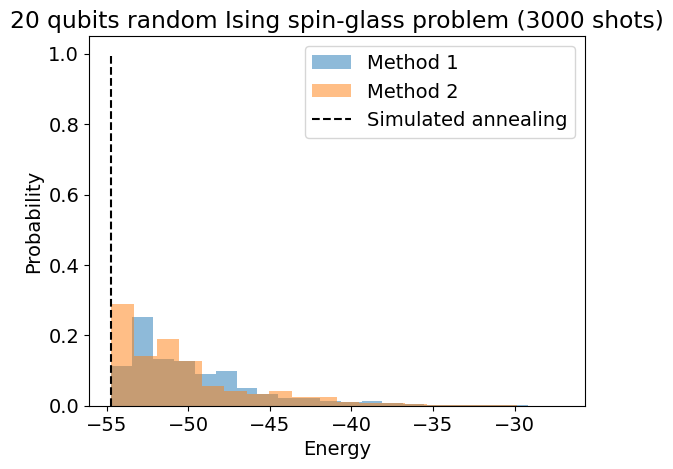

In [16]:
plt.hist(energies_fqa_1, weights=list(probs_fqa_1.values()), bins=20, label="Method 1",alpha=0.5)
plt.hist(energies_fqa_2, weights=list(probs_fqa_2.values()), bins=20, label="Method 2",alpha=0.5)
plt.vlines(x=gs_energy_sa, ymin = 0, ymax = 1, color='k', ls='--', label='Simulated annealing')
plt.legend()
plt.title(f"{num_qubits} qubits random Ising spin-glass problem ({num_reads} shots)")
plt.xlabel("Energy")
plt.ylabel("Probability")
plt.show()

# Bias field

In [17]:
# bias field as the min energy state
bs_min = list(probs_fqa_1.keys())[0]
hb = {i: -(1- 2*int(bit)) for i, bit in enumerate(bs_min)}

In [18]:
new_h = {spin : val + hb[spin] for spin, val in h.items()} #antibias
hb_scale, Jb_scale, scale_b = scale_coeffs(new_h, J)
embedding = find_embedding(Jb_scale, target)
sampler_fixed = FixedEmbeddingComposite(qpu, embedding)

# add flux bias
fb = [0]*qpu.properties['num_qubits']
for i in range(num_qubits):
    for qubit_phy in embedding[i]:
        fb[qubit_phy] = h_to_fluxbias(hb_scale[i], B=2.014, MAFM=0.443)

In [19]:
sampleset = sampler_fixed.sample_ising(h={}, J=Jb_scale, num_reads=num_reads, # use Jb_scale for method 2
                                         annealing_time=T,
                                         fast_anneal = True,
                                         auto_scale=False, answer_mode="raw",
                                         flux_biases = fb,
                                         chain_strength = 2)

sampleset_bf = sampleset.aggregate()

In [20]:
probs_bf, energies_bf, energy_bf = get_stats(h, J, num_qubits, num_reads, sampleset_bf)
print("Min: ", list(probs_bf.keys())[0], energies_bf [0], list(probs_bf.values())[0])

Min:  00100000111000110111 -52.44376848028442 0.0003333333333333333


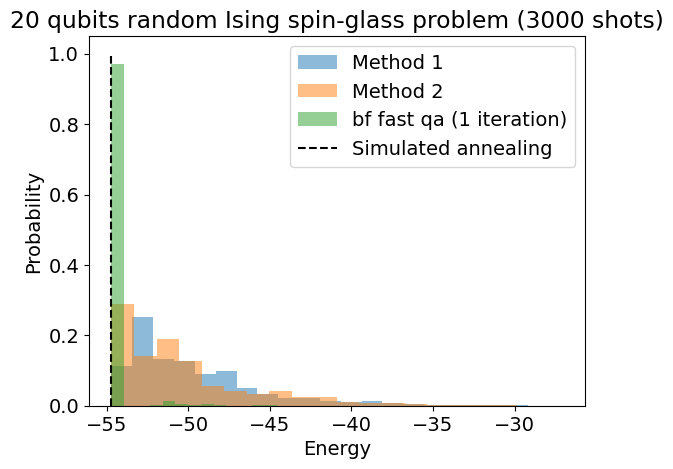

In [21]:
plt.hist(energies_fqa_1, weights=list(probs_fqa_1.values()), bins=20, label="Method 1",alpha=0.5)
plt.hist(energies_fqa_2, weights=list(probs_fqa_2.values()), bins=20, label="Method 2",alpha=0.5)
plt.hist(energies_bf, weights= list(probs_bf.values()), bins=20, label="bf fast qa (1 iteration)",alpha=0.5)

plt.vlines(x=gs_energy_sa, ymin = 0, ymax = 1, color='k', ls='--', label='Simulated annealing')

plt.legend()
plt.title(f"{num_qubits} qubits random Ising spin-glass problem ({num_reads} shots)")
plt.xlabel("Energy")
plt.ylabel("Probability")

plt.show()